# Tutorial 1- Optimal Control and Fishing

(By Zhengwei Wu and Xaq Pitkow)




In [42]:
#@title Import
# Execute the cell below to initialize the notebook environment.

import numpy as np                 # import numpy
import scipy                       # import scipy
from scipy.linalg import inv       # import matrix inversion
import matplotlib.pyplot as plt    # import matplotlib
from ipywidgets import interact, fixed
import ipywidgets as widgets


%matplotlib inline
from IPython import display

---
###Insert Tutorial 1a here (0:29-5:30)
(or maybe want to split out the first part, which is an overview)

---

## Tutorial objectives

In this tutorial, we will implement a binary control task: a Partially Observable Markov Decision Process (POMDP) that describes fishing. The agent (you) seeks reward from two fishing sites without directly observing where the school of fish is. Based on when and where you catch fish, you keep updating your belief about the fish location, i.e. the posterior of the fish given past observations. You should control your position to get the most fish while minimizing the cost of switching sides.

You've already learned about stochastic dynamics, latent states, and measurements. Now we introduce you to the new concepts of **control, utility, and policy**.


---

## Task Description

There are two locations for the fish and you (Left and Right). If you're on the same side as the fish, you'll catch more, with probabilty $q_{\rm high}$ per discrete time step. Otherwise you may still catch fish with probability $q_{\rm low}$. One fish is worth 1 "point".

The fish location $s^{\rm fish}$ is latent. The only information you have about the fish location is when you catch one. Secretly the fish switch sides with a certain probability $p_{\rm sw} = 1 - p_{\rm stay}$.


You are in control of your location. You may stay on your current side with no cost, or switch to the other side and incur an action cost $c$ (again, in units of fish).

You select controls or actions by following a **policy**. This defines what to do in any situation. Here the situation is specified by your location and your belief $b_t$ about the fish location. For optimal control we assume that this belief is the posterior probability over the current fish location, given all the past measurements. We only need one number for this, since the fish are either on the left or the right. So we write 

$$b_t = p(s^{\rm fish}_t = {\rm Right}\  |\  m_{0:t}, a_{0:t-1})$$

where $m$ are the measurements, and $a$ are the controls or actions (stay or switch).

Here we parameterize the policy by a simple threshold on beliefs. (This happens to be optimal if you pick the right threshold!) When your belief that fish are on the current side falls below a threshold $\theta$, you switch to the other side.


In [43]:
##@title Helper class for the binary HMM task

class binaryHMM():
    def __init__(self, params, fish_initial = 0, loc_initial = 0):
        self.params = params
        self.fish_initial = fish_initial
        self.loc_initial = loc_initial


    def fish_state_telegraph(self, fish_past, p_stay):
        """
        fish state update according to telegraph process

        Parameters
        ----------
        fish_past (binary): the fish location (0 for left side, 1 for right side)
        p_stay : the probability that the state of a certain site stays the same

        Returns
        -------
        fish_new (binary): updated fish location
        """
        fish_new = (1 - np.random.binomial(1, p_stay)) ^ fish_past    # ^ is XOR

        return fish_new


    def fish_dynamics(self):
        """
        fish state dynamics according to telegraph process
  
        Returns
        -------
        fish_state (numpy array of binary)
        """
        T, p_stay, rew_probability_high, rew_probability_low, threshold = self.params
        fish_state = np.zeros((2, T), int)  # 1: high-rewarding ; 0: low-rewarding 

        # initialization 
        fish_state[self.fish_initial, 0] = 1    # high-rewarding box
        fish_state[1 - self.fish_initial, 0] = 0

        for t in range(1, T):
            fish_state[0, t] = self.fish_state_telegraph(fish_state[0, t-1], p_stay)
            fish_state[1, t] = 1 - fish_state[0, t]
        
        return fish_state


    def generate_process_lazy(self):
        """
        fish dynamics and measurements if you always stay in the intial location without changing sides

        Returns
        -------
        fish_state (numpy array of binary): states of the two sites
        loc (numpy array of binary): left or right site
        measurement (numpy array of binary): whether a reward is obtained
        """

        T, p_stay, rew_probability_high, rew_probability_low, threshold = self.params
        rp = np.array([rew_probability_low, rew_probability_high])

        fish_state = self.fish_dynamics()
        loc  = np.zeros(T, int)                      # 0: left box, 1: right box
        measurement = np.zeros(T, int)               # 0: no food, 1: get food

        loc[0] = self.loc_initial
        measurement[0] = 0

        for t in range(1, T):
            loc[t] = loc[t - 1]
            # new measurement
            measurement[t] = np.random.binomial(1, rp[fish_state[loc[t], t-1]])

        return fish_state, loc, measurement

    def plot_fish(self, fish_state):
        """
        Plot the fish dynamics
        """
        T = fish_state.shape[1]

        showlen = min(T, 200)
        startT = 0

        endT = startT + showlen
        showT = range(startT, endT)
        time_range = np.linspace(0, showlen - 1)

        fig, ax = plt.subplots(1, 1, figsize=(12, 2))  
        ax.plot(fish_state[0, showT], color='dodgerblue', markersize=10, linewidth=3.0)
        ax.set_xlabel('time', fontsize=18)
        ax.set_ylabel('Fish state', rotation=360, fontsize=18)
        ax.yaxis.set_label_coords(-0.1, 0.25)
        ax.set_xticks([0, showlen, showlen])
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.set_xlim([0, showlen])
        ax.set_ylim([0, 1.1])
        ax.set_yticks([0, 1])
        ax.tick_params(axis='both', which='major', labelsize=18)
        labels = [item.get_text() for item in ax.get_yticklabels()]
        labels[0] = 'Right'
        labels[-1] = 'Left'
        ax.set_yticklabels(labels)

    def plot_measurement(self, measurement):
        """
        Plot the measurements
        """
        T = len(measurement)

        showlen = min(T, 200)
        startT = 0
        endT = startT + showlen
        showT = range(startT, endT)
        time_range = np.linspace(0, showlen - 1)


        fig, ax = plt.subplots(1, 1, figsize=(12, 2))
        ax.plot(measurement[showT], 'r*', markersize=5)
        ax.set_xlabel('time', fontsize=18)
        ax.set_ylabel('Measurement', rotation=360, fontsize=18)
        ax.yaxis.set_label_coords(-0.1, 0.25)
        ax.set_xticks([0, showlen, showlen])
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.set_xlim([0, showlen])
        ax.set_ylim([0, 1.1])
        ax.set_yticks([])
      




First let's take a look at the dynamics of the fish. Based on the provided code, we can generate the fish states to observe the telegraph process.

In [44]:
T = 200

p_stay = .95     # probability fish stay
rew_probability_high = .4    # p(catch fish) when you're on their side
rew_probability_low = .1     # p(catch fish) when you're on other side

params = [T, p_stay, rew_probability_high, rew_probability_low, _]
binaryHMM_test = binaryHMM(params)

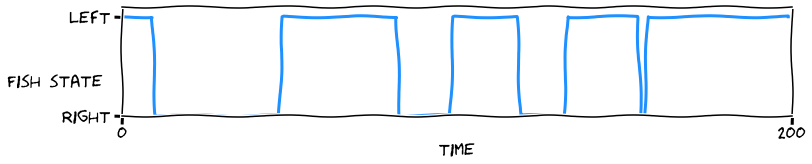

In [45]:
fish_state = binaryHMM_test.fish_dynamics()
with plt.xkcd():
    binaryHMM_test.plot_fish(fish_state)

---
### Exercise 1: Binary POMDP task

Now set $p_{\rm stay} = 1$ so that the state of the two sites are fixed. The variable `fish_initial` indicates the initial side of the fish, which gives high rewarding probability (0 for left side, and 1 for right side). The `loc_initial` indicates the initial location of you. Make the two variables the same first, check the measurements; and then make them different to compare the measurements. 

In [46]:
T = 1000
p_stay = 1      # probability fish stay
rew_probability_high = .4    # p(catch fish) when you're on their side
rew_probability_low = .1     # p(catch fish) when you're on other side

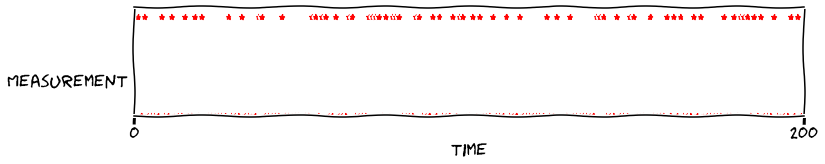

In [47]:
params = [T, p_stay, rew_probability_high, rew_probability_low, _]
binaryHMM_test = binaryHMM(params, fish_initial= 0, loc_initial = 0)
fish_state, loc, measurement = binaryHMM_test.generate_process_lazy()

with plt.xkcd():
    binaryHMM_test.plot_measurement(measurement)

### Exercise 2: Use the binary HMM module to plot dynamics and belief distribution

We have provided a class for the binary HMM task with the agent always staying at one side. Now in this excercise, we extended the module to generate the dynamics including policy and beliefs. With the generated data, we will see what the dynamic looks like, and how the beliefs are distributed, etc.

**Instructions**

* You must code a policy based on threshold in `def policy_threshold(self, threshold, belief, loc)`. The policy takes three inputs: your belief that the fish is on the right (a real number between 0 and 1), your location ("Left" or "Right"), and an action threshold. When your belief that you are on the same side as the fish drops below the threshold, you choose to switch, and otherwise stay. A lazy policy function `def policy_lazy(self, belief, loc)` is provided in which you always stay on one side. 

* For convenience, your belief at time *t* is actually a 2-dimensional vector, with the first element being the belief that the fish are on the left, and the second element is the belief the fish are on the right. You will need to return the action for time *t*, which takes the value of "stay" or "switch".



In [48]:
  #@title Exercise
  
  def policy_threshold(threshold, belief, loc):
      """
      chooses whether to switch side based on whether the belief on the current site drops below the threshold

      Parameters
      ----------
      threshold (float): the threshold of belief on the current site, 
                          when the belief is lower than the threshold, switch side 
      belief (numpy array of float, 2-dimensional): the belief on the two sites at a certain time
      loc (binary) : the location of the agent at a certain time

      Returns
      -------
      act (string): "stay" or ""switch
      """
      ###############################################################################
      ## Insert code to:
      ## generate actions (Stay or Switch) for current belief and location
      ##
      ## Belief is a 2d vector: first element = Prob( fish on Right | measurements )
      ##                       second element = Prob( fish on Left  | measurements )
      ## Returns "switch" if Belief that fish are in your current location < threshold
      ##         "stay" otherwise
      ###############################################################################
      # act = ....

      return act
  
  def policy_lazy(belief, loc):
      """
      This function is a lazy policy where stay is also taken
      """
      act = "stay"

      return act

In [49]:
  # to_remove solution
  def policy_threshold(threshold, belief, loc):
      """
      chooses whether to switch side based on whether the belief on the current site drops below the threshold

      Parameters
      ----------
      threshold (float): the threshold of belief on the current site, 
                          when the belief is lower than the threshold, switch side 
      belief (numpy array of float, 2-dimensional): the belief on the two sites at a certain time
      loc (binary) : the location of the agent at a certain time

      Returns
      -------
      act (string): "stay" or ""switch
      """
      ###############################################################################
      ## Insert code to:
      ## generate actions (Stay or Switch) for current belief and location
      ##
      ## Belief is a 2d vector: first element = Prob( fish on Right | measurements )
      ##                       second element = Prob( fish on Left  | measurements )
      ## Returns "switch" if Belief that fish are in your current location < threshold
      ##         "stay" otherwise
      ###############################################################################
      ###############################################################################
      # Solution to be removed
      if belief[loc]  <= threshold:
          act = "switch"
      else:
          act = "stay"
      ###############################################################################
      # act = ....

      return act
  
  def policy_lazy(belief, loc):
      """
      This function is a lazy policy where stay is also taken
      """
      act = "stay"

      return act

In [50]:
#@title Helper class for binary HMM task with policy

class binaryHMM_belief(binaryHMM):
    def __init__(self, params, fish_initial = 0, loc_initial = 0, choose_policy = 'threshold'):
        binaryHMM.__init__(self, params, fish_initial, loc_initial)
        self.choose_policy = choose_policy

    def generate_process(self):  
        """
        fish dynamics and measurements based on the choosen policy

        Returns
        -------
        belief (numpy array of float): belief on the states of the two sites
        act (numpy array of string): actions over time
        loc (numpy array of binary): left or right site
        measurement (numpy array of binary): whether a reward is obtained
        fish_state (numpy array of binary): states of the two sites
        """
        
        T, p_stay, rew_probability_high, rew_probability_low, threshold = self.params
        fish_state = self.fish_dynamics()   # 1: high-rewarding box; 0: low-rewarding box
        loc  = np.zeros(T, int)               # 0: left box, 1: right box
        measurement = np.zeros(T, int)        # 0: no food, 1: get food
        act  = np.empty(T, dtype='object')    # "stay", or "switch" 
        belief = np.zeros((2, T), float)      # the probability that a certain box is in high-rewarding state,
                                              # the beliefs on the two boxes sum up to be 1

        rew_prob = np.array([rew_probability_low, rew_probability_high]) 

        #initialization 
        loc[0] = 0
        measurement[0] = 0
        belief_0 = np.random.random(1)[0]
        belief[:, 0] = np.array([belief_0, 1 - belief_0])
        act[0] = self.policy(threshold, belief[:, 0], loc[0])       

        for t in range(1, T):
          if act[t - 1] == "stay":
                loc[t] = loc[t - 1]
          else:  
              loc[t] = 1 - loc[t - 1]

          # new measurement
          measurement[t] = np.random.binomial(1, rew_prob[fish_state[loc[t], t-1]])
          belief[0, t] = self.belief_update(belief[0, t - 1] , loc[t], 
                                            measurement[t], p_stay)
          belief[1, t] = 1 - belief[0, t]

          act[t] = self.policy(threshold, belief[:, t], loc[t])

        return belief, loc, act, measurement, fish_state
    
    def policy(self, threshold, belief, loc):
        """
        chooses policy based on whether it is lazy policy or a threshold-based policy

        Parameters
        ----------
        threshold (float): the threshold of belief on the current site, 
                           when the belief is lower than the threshold, switch side 
        belief (numpy array of float): the belief on the two sites
        loc (binary) : the location of the agent

        Returns
        -------
        act (string): "stay" or ""switch
        """

        if self.choose_policy == "threshold":
            act = policy_threshold(threshold, belief, loc)
        if self.choose_policy == "lazy":
            act = policy_lazy(belief, loc)
        
        return act
    
    def belief_update(self, belief_past, loc, meas, p_stay):
        """
        using PAST belief on the LEFT box, CURRENT location and measurement to update belief
        """
        rew_prob_matrix = np.array([[1 - rew_probability_high, rew_probability_high], 
                           [1 - rew_probability_low, rew_probability_low]])
        
        # update belief posterior, p(s[t] | meas(0-t), act(0-t-1))
        belief_0 = (belief_past * p_stay  + (1 - belief_past) * (1 - p_stay)) * rew_prob_matrix[loc, meas]
        belief_1 = ((1 - belief_past) * p_stay + belief_past * (1 - p_stay)) * rew_prob_matrix[1-loc, meas]

        belief_0 = belief_0 / (belief_0 + belief_1)

        return belief_0   

    def plot_dynamics(self, belief, loc, act, meas, fish_state):
        """
        Plot the dynamics of 200 time points
        """

        T = len(meas)

        showlen = min(T, 200)
        startT = 0

        endT = startT + showlen
        showT = range(startT, endT)
        time_range = np.linspace(0, showlen - 1)

        fig, [ax0, ax_loc, ax1] = plt.subplots(3, 1, figsize=(15, 6))
        
        ax0.plot(fish_state[0, showT], color='dodgerblue', markersize=10, linewidth=3.0)
        ax0.set_ylabel('Fish state', rotation=360, fontsize=18)
        ax0.yaxis.set_label_coords(-0.1, 0.25)
        ax0.set_xticks([0, showlen, showlen])
        ax0.tick_params(axis='both', which='major', labelsize=18)
        ax0.set_xlim([0, showlen])
        ax0.set_ylim([0, 1.1])
        ax0.set_yticks([0, 1])
        ax0.tick_params(axis='both', which='major', labelsize=18)
        labels = [item.get_text() for item in ax0.get_yticklabels()]
        labels[0] = 'Right'
        labels[-1] = 'Left'
        ax0.set_yticklabels(labels)

        ax1.plot(belief[0, showT], color='dodgerblue', markersize=10, linewidth=3.0)
        ax1.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
        ax1.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')
        ax1.yaxis.set_label_coords(-0.1, 0.25)
        ax1.set_xlabel('time', rotation=360, fontsize=18)
        ax1.set_ylabel('Belief on \n left', rotation=360, fontsize=18)
        ax1.tick_params(axis='both', which='major', labelsize=18)
        ax1.set_xlim([0, showlen])
        ax1.set_yticks([0, 1])
        ax1.set_ylim([0, 1.1])
        ax1.set_xticks([0, showlen, showlen])
        
        ax2 = ax1.twinx()
        
        ax2.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
        ax2.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')  
        labels[0] = 'threshold to switch \n from left to right'
        labels[-1] = 'threshold to switch \n from right to left'
        ax2.set_yticks([threshold, 1 - threshold])
        ax2.set_ylim([0, 1.1])
        ax2.tick_params(axis='both', which='major', labelsize=18)
        labels = [item.get_text() for item in ax2.get_yticklabels()]
        ax2.set_yticklabels(labels)
        
        
        act_int = (act == "switch" ).astype(int)
        ax_loc.plot(1 - loc[showT], 'g.-', markersize=8, linewidth=5)
        ax_loc.set_xlabel('time', fontsize=18)
        ax_loc.set_ylabel('Your state', rotation=360, fontsize=18)
        ax_loc.plot((act_int[showT] - .1) * .8, 'rv', markersize=12, label = 'action')
        ax_loc.plot(meas[showT] * .5, 'm*', markersize=5, label = 'reward')
        ax_loc.legend(loc="upper right", fontsize = 12)
        ax_loc.set_xlim([0, showlen])
        ax_loc.set_ylim([0, 1])
        ax_loc.set_xticks([0, showlen, showlen])
        ax_loc.tick_params(axis='both', which='major', labelsize=18)
        labels = [item.get_text() for item in ax_loc.get_yticklabels()]
        labels[0] = 'Right'
        labels[-1] = 'Left'
        ax_loc.set_yticklabels(labels)

        plt.tight_layout()
        plt.show()
        
    
    def belief_histogram(self, belief, bins = 100):
        """
        Plot the histogram of belief states
        """
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.hist(belief, bins)
        ax.set_xlabel('belief', fontsize = 18)
        ax.set_ylabel('count', fontsize = 18)
        plt.show()



--- 

* With the class defined above, create an object of `binaryHMM_belief` given parameters of the dynamic *params* and a parameter for policy. 
* The parameter for policy can be either *"lazy"* or *"threshold"*. In the following example the policy is the lazy policy. After you compelete the code for the policy based on threshold in Excercise 1, comment the line using the "lazy" policy, and uncomment the line with "threshold" policy".
* We have provided an example of the parameters. You can play with the parameters to see the dynamics.
* Plot the histgram of the belief states to check the distributions.

In [51]:
T = 10000

p_stay = .95     # probability fish stay
rp_high = .4    # p(catch fish) when you're on their side
rp_low = .1     # p(catch fish) when you're on other side

threshold = .2    # threshold of belief below which switching is taken

params = [T, p_stay, rew_probability_high, rew_probability_low, threshold]

#binaryHMM_test = binaryHMM_belief(params, choose_policy="lazy")
binaryHMM_test = binaryHMM_belief(params, choose_policy="threshold")


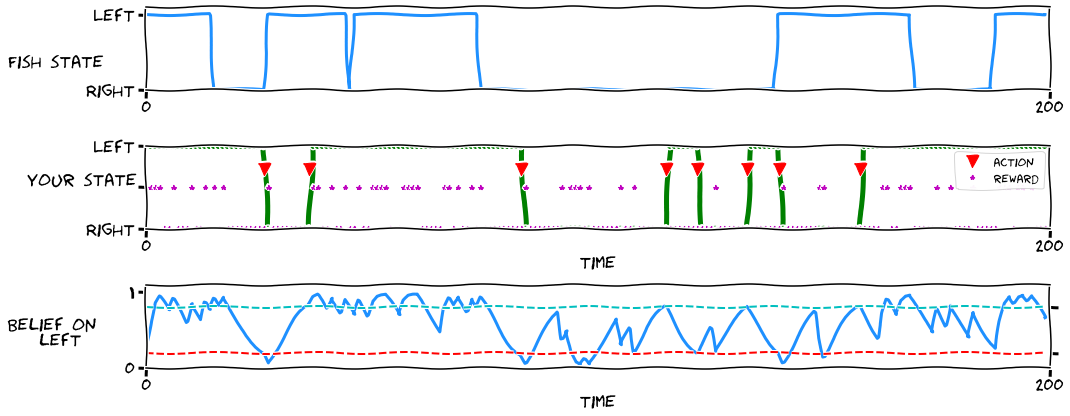

In [52]:
"""
Plot the dynamics of the binaryHMM task
"""
belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
with plt.xkcd():
    binaryHMM_test.plot_dynamics(belief, loc, act, measurement, fish_state)

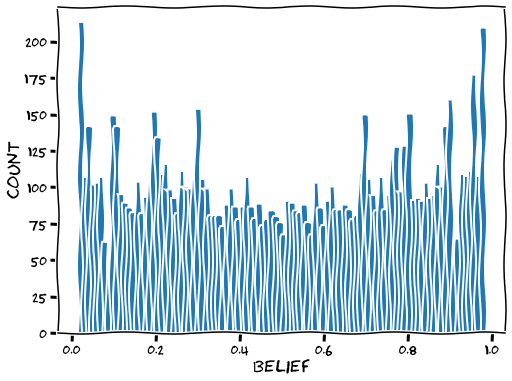

In [53]:
"""
Check the distribution of beliefs.
"""
with plt.xkcd():
    binaryHMM_test.belief_histogram(belief[0, :]) # histgram of the belief on the left box

### Exercise 3: Value function 
Now we have generated behavioral for a parameterized policy. Let's calculate the value of that policy. 

Specifically, here the value is total expected utility per unit time.

$$V(\theta) = \frac{1}{T}\left(\sum_t U_s(s_t) + U_a(a_t)\right)$$ 

where $U_s(s_t)$ is the instataneous utility from the site, and $U_a(a_t)$ is the negative cost for switching.

**Instructions**
* Fill in the function `value_function(measurement, act, cost_sw)` given a sequence of measurements, actions, and the cost of switching. 

In [54]:
#@title Exercise
def value_function(measurement, act, cost_sw):
    """
    value function 
    """
    act_int = (act == "switch" ).astype(int)       # convert labels to binary
    T = len(measurement)   

    ###############################################################################
    ## Insert your code here to:
    ##        compute the value function
    ###############################################################################

    #value = ...     # rate of catching fish - costs

    return value

In [55]:
# to_remove solution
def value_function(measurement, act, cost_sw):
    """
    value function 
    """
    act_int = (act == "switch" ).astype(int)       # convert labels to binary
    T = len(measurement)   

    ###############################################################################
    ## Insert your code here to:
    ##        compute the value function
    ###############################################################################
    ###############################################################################
    # Solution to be removed
    value = (np.sum(measurement) - np.sum(act_int) * cost_sw) / T     # rate of catching fish - costs
    ###############################################################################

    #value = ...     # rate of catching fish - costs

    return value

### Exercise 4: Finding optimal policy based on value function 
Let's find the threshold that yields the highest total value. We have provided code for plotting value versus threshold. You can then find the threshold $\theta^*$ with the highest value, i.e. the policy that gives optimal control.






In [56]:
#@title Helper function to plot the value function and threshold 

def plot_value_threshold(cost_sw, T, p_stay, 
                         rew_probability_high, rew_probability_low, step = 0.05):
    params = [T, p_stay, rew_probability_high, rew_probability_low, _]
        
    threshold_array, value_array = value_threshold(params, cost_sw, step)

    fig_, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(threshold_array, value_array, 'b')
    ax.set_ylim([np.min(value_array), np.max(value_array)])
    ax.set_title('threshold vs value with switching cost c = %.2f'%cost_sw, fontsize = 20)
    ax.set_xlabel('threshold', fontsize = 16)
    ax.set_ylabel('value', fontsize = 16)
    plt.show()

In [57]:
# Brute force search for optimal policy: what is the best threshold?
# This function is needed for the second exercise.

def value_threshold(params, cost_sw, step):
    threshold_array = np.arange(0, 1 + step, step)
    value_array = np.zeros(threshold_array.shape)
    
    T, p_stay, rew_probability_high, rew_probability_low, _ = params
    
    for i in range(len(threshold_array)):
        threshold = threshold_array[i]
        
        params = [T, p_stay, rew_probability_high, rew_probability_low, threshold]
        binaryHMM_test = binaryHMM_belief(params, choose_policy="threshold")
        belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
        
        value_array[i] = value_function(measurement, act, cost_sw)
    
    return threshold_array, value_array


In [58]:
T = 10000
p_stay = .95          # state transiton probability
rew_probability_high = .4
rew_probability_low = .1

cost_sw = 1

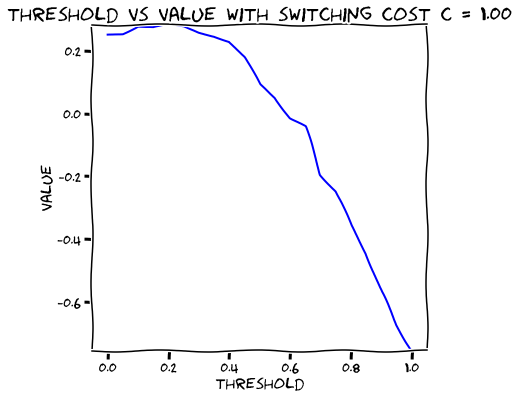

In [59]:
with plt.xkcd():
    plot_value_threshold(cost_sw, T, p_stay, rew_probability_high, rew_probability_low)

Now tweak the other parameters and explore the resultant values. 

In [65]:
_ = interact(plot_value_threshold, cost_sw = (-1,1, .2), 
             T = fixed(T), p_stay = p_stay, rew_probability_high = rew_probability_high, 
             rew_probability_low = rew_probability_low, step = fixed(0.05))

interactive(children=(FloatSlider(value=0.0, description='cost_sw', max=1.0, min=-1.0, step=0.2), FloatSlider(…